In [ ]:
pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns

In [ ]:
spark = SparkSession.builder.appName('Cardiovascular').getOrCreate()
Cardiovascular = spark.read.csv('/content/drive/MyDrive/Big Data & Predictive Analytics Lanjut/Dataset/Cardiovascular_Disease_Dataset.csv', header = True, inferSchema = True)
# melihat tipe data dari dataset
Cardiovascular.show()

+---------+---+------+---------+---------+---------------+-----------------+---------------+------------+-------------+-------+-----+----------------+------+
|patientid|age|gender|chestpain|restingBP|serumcholestrol|fastingbloodsugar|restingrelectro|maxheartrate|exerciseangia|oldpeak|slope|noofmajorvessels|target|
+---------+---+------+---------+---------+---------------+-----------------+---------------+------------+-------------+-------+-----+----------------+------+
|   103368| 53|     1|        2|      171|              0|                0|              1|         147|            0|    5.3|    3|               3|     1|
|   119250| 40|     1|        0|       94|            229|                0|              1|         115|            0|    3.7|    1|               1|     0|
|   119372| 49|     1|        2|      133|            142|                0|              0|         202|            1|    5.0|    1|               0|     0|
|   132514| 43|     1|        0|      138|          

In [ ]:
# melihat jumlah dataset
Cardiovascular.count()

1000

## pre-processing

In [ ]:
Cardiovascular.printSchema()

root
 |-- patientid: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- chestpain: integer (nullable = true)
 |-- restingBP: integer (nullable = true)
 |-- serumcholestrol: integer (nullable = true)
 |-- fastingbloodsugar: integer (nullable = true)
 |-- restingrelectro: integer (nullable = true)
 |-- maxheartrate: integer (nullable = true)
 |-- exerciseangia: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- noofmajorvessels: integer (nullable = true)
 |-- target: integer (nullable = true)



In [ ]:
# Melakukan perbaikan pada penamaan kolom
Cardiovascular = Cardiovascular.withColumnRenamed("patientid", "ID")\
               .withColumnRenamed("age", "Usia")\
               .withColumnRenamed("gender", "Gender")\
               .withColumnRenamed("chestpain", "Nyeri_Dada")\
               .withColumnRenamed("restingBP", "RestingBP")\
               .withColumnRenamed("serumcholestrol", "Kolesterol")\
               .withColumnRenamed("fastingbloodsugar", "Gula_Darah")\
               .withColumnRenamed("restingrelectro", "Restingrelectro")\
               .withColumnRenamed("maxheartrate", "Detak_Jantung")\
               .withColumnRenamed("exerciseangia", "Exerciseangia")\
               .withColumnRenamed("oldpeak", "Oldpeak")\
               .withColumnRenamed("slope", "Slope")\
               .withColumnRenamed("noofmajorvessels", "Noofmajorvessels")\
               .withColumnRenamed("target", "Cardiovascular_Disease")
Cardiovascular.show()

+------+----+------+----------+---------+----------+----------+---------------+-------------+-------------+-------+-----+----------------+----------------------+
|    ID|Usia|Gender|Nyeri_Dada|RestingBP|Kolesterol|Gula_Darah|Restingrelectro|Detak_Jantung|Exerciseangia|Oldpeak|Slope|Noofmajorvessels|Cardiovascular_Disease|
+------+----+------+----------+---------+----------+----------+---------------+-------------+-------------+-------+-----+----------------+----------------------+
|103368|  53|     1|         2|      171|         0|         0|              1|          147|            0|    5.3|    3|               3|                     1|
|119250|  40|     1|         0|       94|       229|         0|              1|          115|            0|    3.7|    1|               1|                     0|
|119372|  49|     1|         2|      133|       142|         0|              0|          202|            1|    5.0|    1|               0|                     0|
|132514|  43|     1|        

In [ ]:
# Melihat missing value dalam dataset
from pyspark.sql.functions import col, count

for colname in Cardiovascular.columns:
  null_count = Cardiovascular.filter(col(colname).isNull()).count()
  print(f"jumlah nilai null pada setiap kolom {colname} : {null_count}")

jumlah nilai null pada setiap kolom ID : 0
jumlah nilai null pada setiap kolom Usia : 0
jumlah nilai null pada setiap kolom Gender : 0
jumlah nilai null pada setiap kolom Nyeri_Dada : 0
jumlah nilai null pada setiap kolom RestingBP : 0
jumlah nilai null pada setiap kolom Kolesterol : 0
jumlah nilai null pada setiap kolom Gula_Darah : 0
jumlah nilai null pada setiap kolom Restingrelectro : 0
jumlah nilai null pada setiap kolom Detak_Jantung : 0
jumlah nilai null pada setiap kolom Exerciseangia : 0
jumlah nilai null pada setiap kolom Oldpeak : 0
jumlah nilai null pada setiap kolom Slope : 0
jumlah nilai null pada setiap kolom Noofmajorvessels : 0
jumlah nilai null pada setiap kolom Cardiovascular_Disease : 0


In [ ]:
# Summary (Describe)
Cardiovascular.describe().show()

+-------+----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+----------------------+
|summary|              ID|             Usia|            Gender|       Nyeri_Dada|        RestingBP|        Kolesterol|        Gula_Darah|   Restingrelectro|    Detak_Jantung|     Exerciseangia|           Oldpeak|            Slope|  Noofmajorvessels|Cardiovascular_Disease|
+-------+----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+----------------------+
|  count|            1000|             1000|              1000|             1000|             1000|              1000|              1000|              1000|             1000|       

In [ ]:
# Mengambil kolom yang memiliki fitur numerik
numeric_features = [t[0] for t in Cardiovascular.dtypes if t[1] in ['int','double']]
numeric_summary = Cardiovascular.select(numeric_features).summary()
numeric_summary.show(truncate=False)

+-------+----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+----------------------+
|summary|ID              |Usia             |Gender            |Nyeri_Dada       |RestingBP        |Kolesterol        |Gula_Darah        |Restingrelectro   |Detak_Jantung    |Exerciseangia     |Oldpeak           |Slope            |Noofmajorvessels  |Cardiovascular_Disease|
+-------+----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+----------------------+
|count  |1000            |1000             |1000              |1000             |1000             |1000              |1000              |1000              |1000             |1000   

In [ ]:
data_take = Cardiovascular.limit(5)
transposed_data = data_take.select([col(column).alias(str(column)) for column in data_take.columns]).toPandas().transpose()
print(transposed_data)

                               0         1         2         3         4
ID                      103368.0  119250.0  119372.0  132514.0  146211.0
Usia                        53.0      40.0      49.0      43.0      31.0
Gender                       1.0       1.0       1.0       1.0       1.0
Nyeri_Dada                   2.0       0.0       2.0       0.0       1.0
RestingBP                  171.0      94.0     133.0     138.0     199.0
Kolesterol                   0.0     229.0     142.0     295.0       0.0
Gula_Darah                   0.0       0.0       0.0       1.0       0.0
Restingrelectro              1.0       1.0       0.0       1.0       2.0
Detak_Jantung              147.0     115.0     202.0     153.0     136.0
Exerciseangia                0.0       0.0       1.0       0.0       0.0
Oldpeak                      5.3       3.7       5.0       3.2       5.3
Slope                        3.0       1.0       1.0       2.0       3.0
Noofmajorvessels             3.0       1.0       0.

In [ ]:
import pandas as pd
pd.DataFrame(Cardiovascular.take(10), columns=Cardiovascular.columns).transpose()

,0,1,2,3,4,5,6,7,8,9
ID,103368.0,119250.0,119372.0,132514.0,146211.0,148462.0,168686.0,170498.0,188225.0,192523.0
Usia,53.0,40.0,49.0,43.0,31.0,24.0,79.0,52.0,62.0,61.0
Gender,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
Nyeri_Dada,2.0,0.0,2.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0
RestingBP,171.0,94.0,133.0,138.0,199.0,173.0,130.0,127.0,121.0,190.0
Kolesterol,0.0,229.0,142.0,295.0,0.0,0.0,240.0,345.0,357.0,181.0
Gula_Darah,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Restingrelectro,1.0,1.0,0.0,1.0,2.0,0.0,2.0,0.0,1.0,1.0
Detak_Jantung,147.0,115.0,202.0,153.0,136.0,161.0,157.0,192.0,138.0,150.0
Exerciseangia,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
grouped_data = Cardiovascular.groupBy('Cardiovascular_Disease').count()
grouped_data.show()

+----------------------+-----+
|Cardiovascular_Disease|count|
+----------------------+-----+
|                     1|  580|
|                     0|  420|
+----------------------+-----+



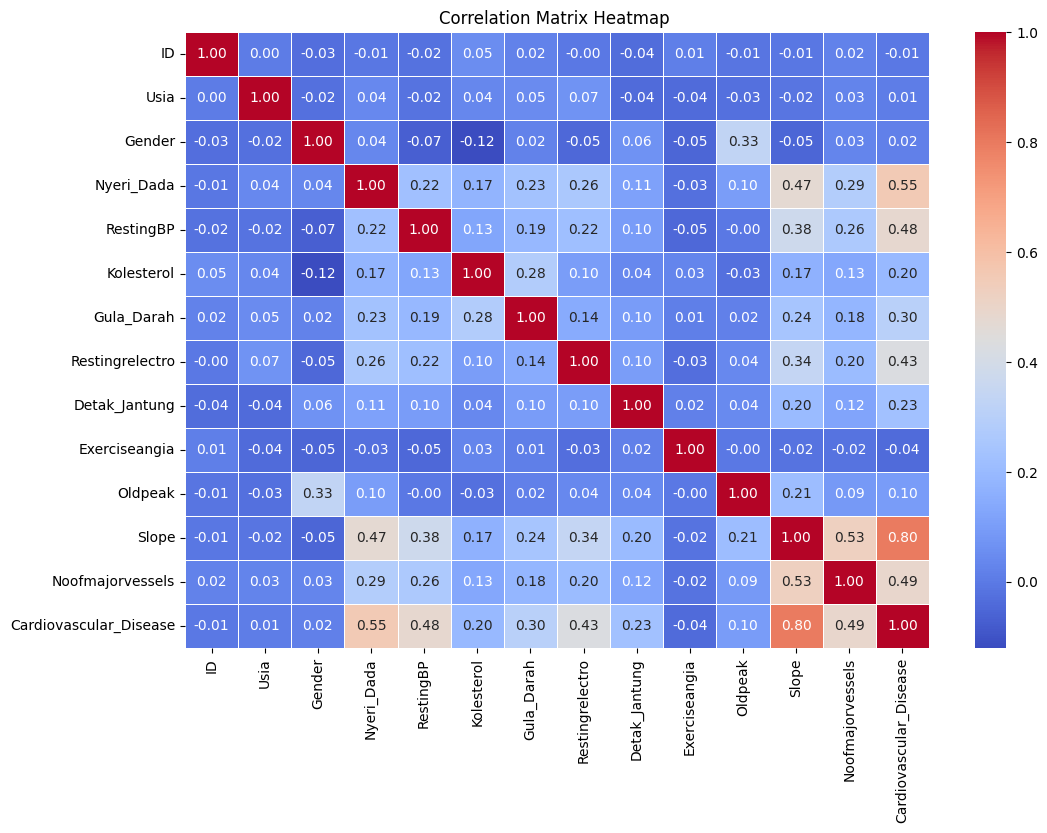

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt

integer_columns = [col_name for col_name, col_type in Cardiovascular.dtypes if col_type in ['int','double']]
Cardiovascular_assembler = VectorAssembler(inputCols=integer_columns, outputCol="features")
for c in integer_columns:
      median_value = Cardiovascular.approxQuantile(c, [0.5], 0.0)[0]
      Cardiovascular = Cardiovascular.na.fill(median_value, [c])

vector_assembler = VectorAssembler(inputCols=integer_columns, outputCol="features")
Cardiovascular_assembled = vector_assembler.transform(Cardiovascular).select("features")

matrix = Correlation.corr(Cardiovascular_assembled, 'features').head()
correlation_matrix = matrix[0].toArray()

correlation_df = pd.DataFrame(correlation_matrix, columns=integer_columns, index=integer_columns)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap ")
plt.show()

In [ ]:
features = ["Noofmajorvessels", "Slope", "Restingrelectro",  "RestingBP", "Nyeri_Dada"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
Cardiovascular = assembler.transform(Cardiovascular).select('features', 'Cardiovascular_Disease')
Cardiovascular.show(truncate=False)

+-----------------------+----------------------+
|features               |Cardiovascular_Disease|
+-----------------------+----------------------+
|[3.0,3.0,1.0,171.0,2.0]|1                     |
|[1.0,1.0,1.0,94.0,0.0] |0                     |
|[0.0,1.0,0.0,133.0,2.0]|0                     |
|[2.0,2.0,1.0,138.0,0.0]|1                     |
|[2.0,3.0,2.0,199.0,1.0]|1                     |
|[2.0,3.0,0.0,173.0,1.0]|1                     |
|[1.0,2.0,2.0,130.0,2.0]|1                     |
|(5,[1,3],[1.0,127.0])  |0                     |
|(5,[2,3],[1.0,121.0])  |0                     |
|[0.0,2.0,1.0,190.0,0.0]|1                     |
|[2.0,2.0,1.0,190.0,1.0]|1                     |
|[1.0,3.0,0.0,192.0,2.0]|1                     |
|(5,[2,3],[1.0,129.0])  |0                     |
|(5,[1,3],[1.0,98.0])   |0                     |
|(5,[1,3],[1.0,170.0])  |0                     |
|[3.0,2.0,0.0,188.0,2.0]|1                     |
|[2.0,2.0,1.0,137.0,3.0]|1                     |
|[1.0,1.0,1.0,200.0,

In [ ]:
train, test = Cardiovascular.randomSplit([0.8, 0.2], seed = 5)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 803
Test Dataset Count: 197


# decission tree

In [ ]:

from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier

# Membuat instance model
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Cardiovascular_Disease', maxDepth=10, maxBins=15)

# Melatih model
dt_model = dt.fit(train)

# Memprediksi menggunakan model
dt_predictions = dt_model.transform(test)

dt_predictions.select('Cardiovascular_Disease', 'rawPrediction', 'prediction', 'probability').show(10)

+----------------------+-------------+----------+--------------------+
|Cardiovascular_Disease|rawPrediction|prediction|         probability|
+----------------------+-------------+----------+--------------------+
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|   [14.0,0.0]|       0.0|           [1.0,0.0]|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
+----------------------+-------------+----------+--------------------+
only s

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Anggap 'predictions' dan 'Cardiovascular_Disease' adalah nilai yang diprediksi dan Cardiovascular_Disease sebenarnya
# Misalnya, dt_predictions = model.transform(test_data), Cardiovascular_Disease = test_data.select('Cardiovascular_Disease').collect()
# Inisialisasi evaluator

evaluator = BinaryClassificationEvaluator()


evaluator_auc = BinaryClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    rawPredictionCol='rawPrediction',
    metricName='areaUnderROC'
)

# Hitung nilai Area Under ROC
auc = evaluator_auc.evaluate(dt_predictions)
print(f'Test Area Under ROC: {auc * 100:.2f}%')


# Ambil nilai prediksi dan label sebagai array untuk perhitungan metrik lainnya
predictions_model= dt_predictions.select('prediction').rdd.flatMap(lambda x: x).collect()
target_model = [int(row.Cardiovascular_Disease) for row in dt_predictions.select('Cardiovascular_Disease').collect()]

# Hitung nilai akurasi
accuracy = accuracy_score(target_model, predictions_model) * 100
print(f'Akurasi: {accuracy:.2f}%')

# Hitung nilai F1-score
f1 = f1_score(target_model, predictions_model) * 100
print(f'Nilai F1-score: {f1:.2f}%')

# Hitung nilai presisi
precision = precision_score(target_model, predictions_model) * 100
print(f'Presisi: {precision:.2f}%')

# Hitung nilai recall
recall = recall_score(target_model, predictions_model) * 100
print(f'Recall: {recall:.2f}%')

# Tampilkan kolom yang diinginkan dari dataframe 'predictions'
dt_predictions.select('Cardiovascular_Disease', 'rawPrediction', 'prediction', 'probability').show(10)

# Hitung jumlah prediksi yang salah
wrong_predictions = dt_predictions.filter(dt_predictions['Cardiovascular_Disease'] != dt_predictions['prediction']).count()
print(f'Jumlah prediksi yang salah: {wrong_predictions}')


Test Area Under ROC: 92.71%
Akurasi: 93.71%
Nilai F1-score: 94.44%
Presisi: 93.87%
Recall: 95.03%
+----------------------+-------------+----------+--------------------+
|Cardiovascular_Disease|rawPrediction|prediction|         probability|
+----------------------+-------------+----------+--------------------+
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|   [14.0,0.0]|       0.0|           [1.0,0.0]|
|                     0|  [225.0,2.0]|       0.0|[

# Logistic regression

In [ ]:

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

# Membuat instance model
lr = LogisticRegression(featuresCol='features', labelCol='Cardiovascular_Disease',  maxIter=20)

# Melatih model
lr_model = lr.fit(train)

# Memprediksi menggunakan model
lr_predictions = lr_model.transform(test)

lr_predictions.select('Cardiovascular_Disease', 'rawPrediction', 'prediction', 'probability').show(10)

+----------------------+--------------------+----------+--------------------+
|Cardiovascular_Disease|       rawPrediction|prediction|         probability|
+----------------------+--------------------+----------+--------------------+
|                     0|[8.46964464916729...|       0.0|[0.99979030456019...|
|                     0|[7.54331981703534...|       0.0|[0.99947064396222...|
|                     0|[7.11324043068836...|       0.0|[0.99918641028247...|
|                     0|[4.55327230847997...|       0.0|[0.98957709934893...|
|                     0|[3.99086080325700...|       0.0|[0.98185165397449...|
|                     0|[3.89161171410000...|       0.0|[0.97999591134404...|
|                     0|[3.89161171410000...|       0.0|[0.97999591134404...|
|                     0|[3.85852868438101...|       0.0|[0.97933695008896...|
|                     0|[3.72619656550501...|       0.0|[0.97648214545786...|
|                     0|[3.72619656550501...|       0.0|[0.97648

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Anggap 'predictions' dan 'Cardiovascular_Disease' adalah nilai yang diprediksi dan Cardiovascular_Disease sebenarnya
# Misalnya, dt_predictions = model.transform(test_data), Cardiovascular_Disease = test_data.select('Cardiovascular_Disease').collect()
# Inisialisasi evaluator

evaluator = BinaryClassificationEvaluator()


evaluator_auc = BinaryClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    rawPredictionCol='rawPrediction',
    metricName='areaUnderROC'
)

# Hitung nilai Area Under ROC
auc = evaluator_auc.evaluate(lr_predictions)
print(f'Test Area Under ROC: {auc * 100:.2f}%')

# Ambil nilai prediksi dan label sebagai array untuk perhitungan metrik lainnya
predictions_model= lr_predictions.select('prediction').rdd.flatMap(lambda x: x).collect()
target_model = [int(row.Cardiovascular_Disease) for row in lr_predictions.select('Cardiovascular_Disease').collect()]

# Hitung nilai akurasi
accuracy = accuracy_score(target_model, predictions_model) * 100
print(f'Akurasi: {accuracy:.2f}%')

# Hitung nilai F1-score
f1 = f1_score(target_model, predictions_model) * 100
print(f'Nilai F1-score: {f1:.2f}%')

# Hitung nilai presisi
precision = precision_score(target_model, predictions_model) * 100
print(f'Presisi: {precision:.2f}%')

# Hitung nilai recall
recall = recall_score(target_model, predictions_model) * 100
print(f'Recall: {recall:.2f}%')

# Tampilkan kolom yang diinginkan dari dataframe 'predictions'
dt_predictions.select('Cardiovascular_Disease', 'rawPrediction', 'prediction', 'probability').show(10)

# Hitung jumlah prediksi yang salah
wrong_predictions = lr_predictions.filter(lr_predictions['Cardiovascular_Disease'] != lr_predictions['prediction']).count()
print(f'Jumlah prediksi yang salah: {wrong_predictions}')


Test Area Under ROC: 99.40%
Akurasi: 95.43%
Nilai F1-score: 96.33%
Presisi: 95.93%
Recall: 96.72%
+----------------------+-------------+----------+--------------------+
|Cardiovascular_Disease|rawPrediction|prediction|         probability|
+----------------------+-------------+----------+--------------------+
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|   [14.0,0.0]|       0.0|           [1.0,0.0]|
|                     0|  [225.0,2.0]|       0.0|[

# GBT classifier

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import GBTClassifier

# Membuat instance model
gbt = GBTClassifier(featuresCol='features', labelCol='Cardiovascular_Disease',  maxIter=10)

# Melatih model
gbt_model = gbt.fit(train)

# Memprediksi menggunakan model
gbt_predictions = gbt_model.transform(test)

gbt_predictions.select('Cardiovascular_Disease', 'rawPrediction', 'prediction', 'probability').show(10)

+----------------------+--------------------+----------+--------------------+
|Cardiovascular_Disease|       rawPrediction|prediction|         probability|
+----------------------+--------------------+----------+--------------------+
|                     0|[1.32380090933194...|       0.0|[0.93386302596079...|
|                     0|[1.32380090933194...|       0.0|[0.93386302596079...|
|                     0|[1.25303901750786...|       0.0|[0.92456681589655...|
|                     0|[1.32380090933194...|       0.0|[0.93386302596079...|
|                     0|[1.32380090933194...|       0.0|[0.93386302596079...|
|                     0|[1.32380090933194...|       0.0|[0.93386302596079...|
|                     0|[1.32380090933194...|       0.0|[0.93386302596079...|
|                     0|[1.32380090933194...|       0.0|[0.93386302596079...|
|                     0|[1.32380090933194...|       0.0|[0.93386302596079...|
|                     0|[1.32380090933194...|       0.0|[0.93386

In [ ]:
from pyspark.ml.evaluation import  BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Anggap 'predictions' dan 'Cardiovascular_Disease' adalah nilai yang diprediksi dan Cardiovascular_Disease sebenarnya
# Misalnya, dt_predictions = model.transform(test_data), Cardiovascular_Disease = test_data.select('Cardiovascular_Disease').collect()
# Inisialisasi evaluator


evaluator = BinaryClassificationEvaluator()


evaluator_auc = BinaryClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    rawPredictionCol='rawPrediction',
    metricName='areaUnderROC'
)

# Hitung nilai Area Under ROC
auc = evaluator_auc.evaluate(lr_predictions)
print(f'Test Area Under ROC: {auc * 100:.2f}%')

# Ambil nilai prediksi dan label sebagai array untuk perhitungan metrik lainnya
predictions_model= gbt_predictions.select('prediction').rdd.flatMap(lambda x: x).collect()
target_model = [int(row.Cardiovascular_Disease) for row in gbt_predictions.select('Cardiovascular_Disease').collect()]

# Hitung nilai akurasi
accuracy = accuracy_score(target_model, predictions_model) * 100
print(f'Akurasi: {accuracy:.2f}%')

# Hitung nilai F1-score
f1 = f1_score(target_model, predictions_model) * 100
print(f'Nilai F1-score: {f1:.2f}%')

# Hitung nilai presisi
precision = precision_score(target_model, predictions_model) * 100
print(f'Presisi: {precision:.2f}%')

# Hitung nilai recall
recall = recall_score(target_model, predictions_model) * 100
print(f'Recall: {recall:.2f}%')

# Tampilkan kolom yang diinginkan dari dataframe 'predictions'
dt_predictions.select('Cardiovascular_Disease', 'rawPrediction', 'prediction', 'probability').show(10)

# Hitung jumlah prediksi yang salah
wrong_predictions = gbt_predictions.filter(gbt_predictions['Cardiovascular_Disease'] != gbt_predictions['prediction']).count()
print(f'Jumlah prediksi yang salah: {wrong_predictions}')


Test Area Under ROC: 99.40%
Akurasi: 95.94%
Nilai F1-score: 96.75%
Presisi: 95.97%
Recall: 97.54%
+----------------------+-------------+----------+--------------------+
|Cardiovascular_Disease|rawPrediction|prediction|         probability|
+----------------------+-------------+----------+--------------------+
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|   [14.0,0.0]|       0.0|           [1.0,0.0]|
|                     0|  [225.0,2.0]|       0.0|[

# Random forest

In [ ]:
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

# Membuat instance model
rfc = RandomForestClassifier(featuresCol='features', labelCol='Cardiovascular_Disease', numTrees=20, maxDepth=2)

# Melatih model
rfc_model = rfc.fit(train)

# Memprediksi menggunakan model
rfc_predictions = rfc_model.transform(test)

rfc_predictions.select('Cardiovascular_Disease', 'rawPrediction', 'prediction', 'probability').show(10)

+----------------------+--------------------+----------+--------------------+
|Cardiovascular_Disease|       rawPrediction|prediction|         probability|
+----------------------+--------------------+----------+--------------------+
|                     0|[18.0755757348385...|       0.0|[0.90377878674192...|
|                     0|[18.0755757348385...|       0.0|[0.90377878674192...|
|                     0|[18.0755757348385...|       0.0|[0.90377878674192...|
|                     0|[18.0755757348385...|       0.0|[0.90377878674192...|
|                     0|[18.0755757348385...|       0.0|[0.90377878674192...|
|                     0|[18.0755757348385...|       0.0|[0.90377878674192...|
|                     0|[18.0755757348385...|       0.0|[0.90377878674192...|
|                     0|[18.0755757348385...|       0.0|[0.90377878674192...|
|                     0|[16.8834945390487...|       0.0|[0.84417472695243...|
|                     0|[18.0755757348385...|       0.0|[0.90377

In [ ]:
from pyspark.ml.evaluation import  BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Anggap 'predictions' dan 'Cardiovascular_Disease' adalah nilai yang diprediksi dan Cardiovascular_Disease sebenarnya
# Misalnya, dt_predictions = model.transform(test_data), Cardiovascular_Disease = test_data.select('Cardiovascular_Disease').collect()
# Inisialisasi evaluator

evaluator = BinaryClassificationEvaluator()


evaluator_auc = BinaryClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    rawPredictionCol='rawPrediction',
    metricName='areaUnderROC'
)

# Hitung nilai Area Under ROC
auc = evaluator_auc.evaluate(rfc_predictions)
print(f'Test Area Under ROC: {auc * 100:.2f}%')


# Ambil nilai prediksi dan label sebagai array untuk perhitungan metrik lainnya
predictions_model= rfc_predictions.select('prediction').rdd.flatMap(lambda x: x).collect()
target_model = [int(row.Cardiovascular_Disease) for row in rfc_predictions.select('Cardiovascular_Disease').collect()]

# Hitung nilai akurasi
accuracy = accuracy_score(target_model, predictions_model) * 100
print(f'Akurasi: {accuracy:.2f}%')

# Hitung nilai F1-score
f1 = f1_score(target_model, predictions_model) * 100
print(f'Nilai F1-score: {f1:.2f}%')

# Hitung nilai presisi
precision = precision_score(target_model, predictions_model) * 100
print(f'Presisi: {precision:.2f}%')

# Hitung nilai recall
recall = recall_score(target_model, predictions_model) * 100
print(f'Recall: {recall:.2f}%')

# Tampilkan kolom yang diinginkan dari dataframe 'predictions'
dt_predictions.select('Cardiovascular_Disease', 'rawPrediction', 'prediction', 'probability').show(10)

# Hitung jumlah prediksi yang salah
wrong_predictions = rfc_predictions.filter(rfc_predictions['Cardiovascular_Disease'] != rfc_predictions['prediction']).count()
print(f'Jumlah prediksi yang salah: {wrong_predictions}')


Test Area Under ROC: 94.92%
Akurasi: 93.71%
Nilai F1-score: 94.34%
Presisi: 95.54%
Recall: 93.17%
+----------------------+-------------+----------+--------------------+
|Cardiovascular_Disease|rawPrediction|prediction|         probability|
+----------------------+-------------+----------+--------------------+
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|  [225.0,2.0]|       0.0|[0.99118942731277...|
|                     0|   [14.0,0.0]|       0.0|           [1.0,0.0]|
|                     0|  [225.0,2.0]|       0.0|[

### Tuning Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Membuat Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='Cardiovascular_Disease')

# Membuat ParamGrid untuk Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.01])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [20, 25, 30])
             .build())

# Inisialisasi evaluator
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    predictionCol='prediction',
    metricName='accuracy'
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    predictionCol='prediction',
    metricName='f1'
)

evaluator_precision_multiclass = MulticlassClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    predictionCol='prediction',
    metricName='weightedPrecision'
)

evaluator_recall_multiclass = MulticlassClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    predictionCol='prediction',
    metricName='weightedRecall'
)

# Inisialisasi CrossValidator dengan LogisticRegression dan ParamGrid
crossValidator_lr = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator_f1,
    numFolds=5
)

# Melatih model menggunakan data pelatihan
cv_model_lr = crossValidator_lr.fit(train)

# Membuat prediksi menggunakan data uji
lr_predictions2 = cv_model_lr.transform(test)

# Menampilkan beberapa hasil prediksi
lr_predictions2.select('Cardiovascular_Disease', 'rawPrediction', 'prediction', 'probability').show(10)

# Evaluasi AUC
auc = evaluator_auc.evaluate(lr_predictions2)
print(f'Test AUC: {auc:.2%}')

# Evaluasi Akurasi
accuracy = evaluator_accuracy.evaluate(lr_predictions2)
print(f'Test Accuracy: {accuracy:.2%}')

# Evaluasi F1-Score
f1_score = evaluator_f1.evaluate(lr_predictions2)
print(f'Test F1-Score: {f1_score:.2%}')

# Evaluasi Presisi Terponderasi (Multiclass)
precision_multiclass = evaluator_precision_multiclass.evaluate(lr_predictions2)
print(f'Presisi : {precision_multiclass:.2%}')

# Evaluasi Recall Terponderasi (Multiclass)
recall_multiclass = evaluator_recall_multiclass.evaluate(lr_predictions2)
print(f'Recall : {recall_multiclass:.2%}')

# Menampilkan prediksi yang salah
wrong_predictions_lr = lr_predictions2.filter(col('Cardiovascular_Disease') != col('prediction'))
wrong_predictions_lr.select('Cardiovascular_Disease', 'rawPrediction', 'prediction', 'probability').show(10)

# Menampilkan jumlah prediksi yang salah
count_wrong_predictions_lr = wrong_predictions_lr.count()
print(f'Jumlah prediksi yang salah: {count_wrong_predictions_lr}')


+----------------------+--------------------+----------+--------------------+
|Cardiovascular_Disease|       rawPrediction|prediction|         probability|
+----------------------+--------------------+----------+--------------------+
|                     0|[5.50541333952040...|       0.0|[0.99595174683843...|
|                     0|[4.82473800788152...|       0.0|[0.99203528889414...|
|                     0|[4.5087101753349,...|       0.0|[0.98910730211460...|
|                     0|[3.44180605743672...|       0.0|[0.96898583798784...|
|                     0|[3.02853889179883...|       0.0|[0.95384689323660...|
|                     0|[2.95560939198038...|       0.0|[0.95052793535397...|
|                     0|[2.95560939198038...|       0.0|[0.95052793535397...|
|                     0|[2.93129955870756...|       0.0|[0.94937217439163...|
|                     0|[2.83406022561629...|       0.0|[0.94448886286664...|
|                     0|[2.83406022561629...|       0.0|[0.94448

### Tuning GBT

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

gbt = GBTClassifier(featuresCol='features', labelCol='Cardiovascular_Disease')

# Membuat ParamGrid untuk Cross Validation
paramGrid = (ParamGridBuilder()
              .addGrid(gbt.maxDepth, [5, 7, 9])
              .addGrid(gbt.maxBins, [42, 84])
              .addGrid(gbt.stepSize, [0.2, 0.02])
              .addGrid(gbt.maxIter, [20, 25, 30])
              .build())

# Inisialisasi evaluator
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    predictionCol='prediction',
    metricName='accuracy'
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    predictionCol='prediction',
    metricName='f1'
)

evaluator_precision_multiclass = MulticlassClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    predictionCol='prediction',
    metricName='weightedPrecision'
)

evaluator_recall_multiclass = MulticlassClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    predictionCol='prediction',
    metricName='weightedRecall'
)

# Inisialisasi CrossValidator dengan GBTClassifier dan ParamGrid
CrossValidator_gbt = CrossValidator(estimator=gbt,
                        estimatorParamMaps=paramGrid,
                        evaluator=evaluator_f1,
                        numFolds=5)

# Melatih model menggunakan data pelatihan
cv_model_gbt = CrossValidator_gbt.fit(train)

# Membuat prediksi menggunakan data uji
gbt_predictions2 = cv_model_gbt.transform(test)

gbt_predictions2.select('Cardiovascular_Disease', 'rawPrediction', 'prediction', 'probability').show(10)

from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Evaluasi AUC
evaluator_auc = BinaryClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    rawPredictionCol='rawPrediction',
    metricName='areaUnderROC'
)
auc = evaluator_auc.evaluate(gbt_predictions2)
print(f'Test AUC: {auc:.2%}')

evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    predictionCol='prediction',
    metricName='accuracy'
)

accuracy = evaluator_accuracy.evaluate(gbt_predictions2)
print(f'Test Accuracy: {accuracy:.2%}')

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    predictionCol='prediction',
    metricName='f1'
)

f1_score = evaluator_f1.evaluate(gbt_predictions2)
print(f'Test F1-Score: {f1_score:.2%}')

# Inisialisasi evaluator Presisi Terponderasi (Multiclass)
evaluator_precision_multiclass = MulticlassClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    predictionCol='prediction',
    metricName='weightedPrecision'
)

# Evaluasi Presisi Terponderasi
precision_multiclass = evaluator_precision_multiclass.evaluate(gbt_predictions2)
print(f'Presisi : {precision_multiclass:.2%}')

# Inisialisasi evaluator Recall Terponderasi (Multiclass)
evaluator_recall_multiclass = MulticlassClassificationEvaluator(
    labelCol='Cardiovascular_Disease',
    predictionCol='prediction',
    metricName='weightedRecall'
)

# Evaluasi Recall Terponderasi
recall_multiclass = evaluator_recall_multiclass.evaluate(gbt_predictions2)
print(f'Recall : {recall_multiclass:.2%}')

wrong_predictions = gbt_predictions2.filter(col('Cardiovascular_Disease') != col('prediction'))

wrong_predictions.select('Cardiovascular_Disease', 'rawPrediction', 'prediction', 'probability').show(10)

count_wrong_predictions = wrong_predictions.count()
print(f'Jumlah prediksi yang salah: {count_wrong_predictions}')


+----------------------+--------------------+----------+--------------------+
|Cardiovascular_Disease|       rawPrediction|prediction|         probability|
+----------------------+--------------------+----------+--------------------+
|                     0|[1.96867890088169...|       0.0|[0.98087329566839...|
|                     0|[1.96867890088169...|       0.0|[0.98087329566839...|
|                     0|[1.90765557421038...|       0.0|[0.97844403783252...|
|                     0|[1.95148384303335...|       0.0|[0.98021732370946...|
|                     0|[1.95148384303335...|       0.0|[0.98021732370946...|
|                     0|[1.95148384303335...|       0.0|[0.98021732370946...|
|                     0|[1.95148384303335...|       0.0|[0.98021732370946...|
|                     0|[1.95148384303335...|       0.0|[0.98021732370946...|
|                     0|[1.95148384303335...|       0.0|[0.98021732370946...|
|                     0|[1.95148384303335...|       0.0|[0.98021

## Visualisasikan Hasil Model Terbaik

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


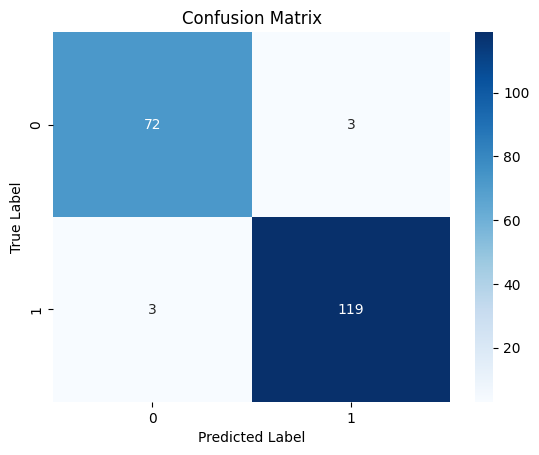

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

# Konversi DataFrame ke RDD
prediction_and_labels = lr_predictions2.select('prediction', 'Cardiovascular_Disease').rdd.map(lambda row: (float(row['prediction']), float(row['Cardiovascular_Disease'])))

# Inisialisasi MulticlassMetrics
metrics = MulticlassMetrics(prediction_and_labels)

# Tampilkan confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Konversi confusion matrix ke tipe data integer
confusion_matrix = confusion_matrix.astype(int)

# Tampilkan confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


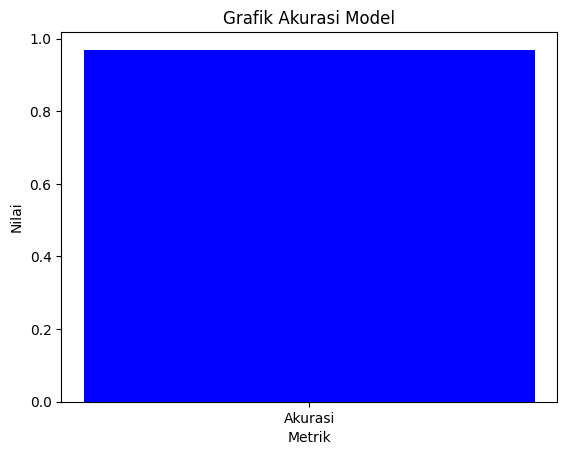

In [ ]:
import matplotlib.pyplot as plt

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Cardiovascular_Disease", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(lr_predictions2)


# Data untuk diplot
labels = ['Akurasi']
values = [accuracy]

# Buat plot bar
plt.bar(labels, values, color=['blue'])

# Tambahkan label dan judul
plt.xlabel('Metrik')
plt.ylabel('Nilai')
plt.title('Grafik Akurasi Model')

# Tampilkan plot
plt.show()